# **Flowers classifier**

In [0]:
!pip install fastai2
!pip install nbdev
!pip install azure-cognitiveservices-search-imagesearch
!pip install voila
!jupyter serverextension enable voila --sys-prefix

In [0]:
from utils import *
from fastai2.vision.all import *
from fastai2.vision.widgets import *

In [0]:
key = '2ca959c66ac7423aa2c9a456f207d062'

In [0]:
all_flowers = ['spirea white', 'wisteria', 'japanise quince', 'lily of the valley']

In [0]:
path = Path('flowers')

In [18]:
if not path.exists():
  path.mkdir()
for flower in all_flowers:
  dest = (path/flower)
  dest.mkdir(exist_ok= True)
  results = search_images_bing(key, flower)
  download_images(dest, urls=results.attrgot('content_url'))

In [0]:
fns = get_image_files(path)

In [27]:
failed = verify_images(fns)
failed

(#0) []

In [28]:
failed.map(Path.unlink)

(#0) []

In [0]:
flowers = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms= Resize(128)
)

In [0]:
dls = flowers.dataloaders(path)

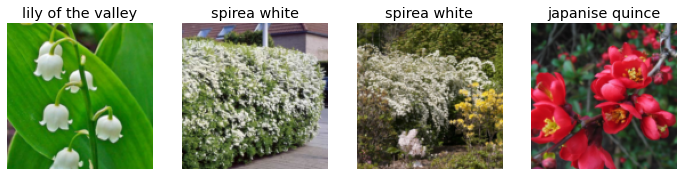

In [32]:
dls.train.show_batch(max_n= 4, nrows= 1)

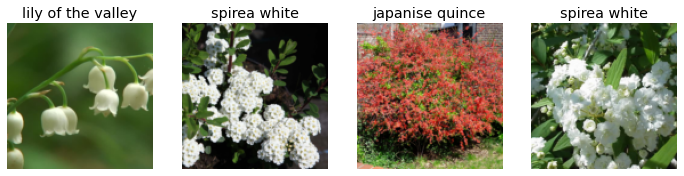

In [33]:
dls.valid.show_batch(max_n= 4, nrows= 1)

In [0]:
flowers = flowers.new(
    item_tfms= RandomResizedCrop(224, min_scale=0.5),
    batch_tfms= aug_transforms()
)
dls = flowers.dataloaders(path)

In [35]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.713059,0.809177,0.258621,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.360619,0.173204,0.051724,00:16
1,0.245732,0.135992,0.034483,00:16
2,0.168719,0.135155,0.034483,00:15
3,0.123846,0.126745,0.034483,00:16


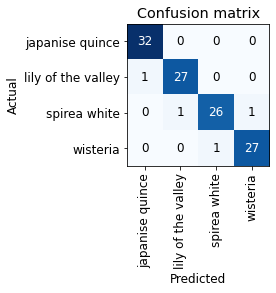

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [43]:
image = PILImage.create('fll.jpg')
learn.predict(image)

('wisteria',
 tensor(3),
 tensor([5.2604e-06, 2.1410e-06, 8.3315e-06, 9.9998e-01]))

In [0]:
learn.export()

In [0]:
learn_inf = load_learner(Path()/'export.pkl')


In [0]:
btn_upload = SimpleNamespace(data = ['fll.jpg'])

In [78]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [0]:
img = PILImage.create(btn_upload.data[-1])

In [72]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [73]:
pred, pred_idx, probs = learn_inf.predict(img)

In [74]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: wisteria; Probability: 1.0000')

In [75]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [0]:

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [80]:
VBox([widgets.Label('Select your flower'), 
      btn_upload, btn_run, out_pl, lbl_pred])